<a href="https://colab.research.google.com/github/williamjshipman/autoencoder_tutorial/blob/master/src/mnist_basic_auto_encoders.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Basic auto-encoders demo
This notebook is going to show some basic types of auto-encoders applied to the MNIST digits data set.

In [8]:
!pip install tensorflow

In [37]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 1247046766253665819
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 15256354588806270868
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 2288665351143599269
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 15956161332
locality {
  bus_id: 1
  links {
  }
}
incarnation: 4924776212496342921
physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"
]


In [9]:
from matplotlib import pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split

import tensorflow as tf

print(f'TensorFlow version: {tf.__version__}')

TensorFlow version: 1.15.0


In [10]:
# Load the MNIST digits data set. Keras makes this easy.
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Convolutional networks expect 4-D arrays: no. of samples X height X width X no. of channels.
# The MNIST images are just missing the channels dimension.
x_train = np.expand_dims(x_train, axis=-1)
x_test = np.expand_dims(x_test, axis=-1)
print(f'MNIST data shape: {x_train.shape}')

# Each pixel is a byte, with a value from 0 to 255. This step converts to floating point a normalizes the data.
x_train = x_train.astype(np.float32) / 255
x_test = x_test.astype(np.float32) / 255
print(f'data type: {x_test.dtype}')

MNIST data shape: (60000, 28, 28, 1)
data type: float32


# Utility functions
The following functions are going to be useful for training and testing the auto-encoders and displaying their output. The `test_random_image` function does just that, it picks an image at random, gives it to the encoder and decoder models to get the encoded and reconstructed form of the image, and displays the original image, the reconstructed version, the error, and the encoded form of the image.

In [0]:
def test_random_image(x: np.ndarray, encoder: tf.keras.Model, decoder: tf.keras.Model, subplot_idx: int, num_examples: int):
    idx = np.random.randint(x.shape[0])
    img = x[idx:(idx+1), :, :]
    encoded_img = encoder.predict(img)
    decoded_img = decoder.predict(img)
    ax1 = plt.subplot(4, num_examples, subplot_idx + 1)
    ax1.imshow(img[0, :, :, 0])
    ax2 = plt.subplot(4, num_examples, subplot_idx + 1 + num_examples)
    ax2.imshow(decoded_img[0, :, :, 0])
    ax3 = plt.subplot(4, num_examples, subplot_idx + 1 + 2 * num_examples)
    ax3.imshow(img[0, :, :, 0] - decoded_img[0, :, :, 0])
    ax4 = plt.subplot(4, num_examples, subplot_idx + 1 + 3 * num_examples)
    if len(encoded_img.shape) == 4:
        ax4.imshow(encoded_img[0, :, :, 0])
    else:
        ax4.plot(encoded_img.flatten())

The code for doing the training and testing the trained auto-encoder on the test data set is next. First, I split the training data into a training and a validation set. These two sets get used to make two `ImageDataGenerator` objects, so that I can use data augmentation to expand my training data size.

Once training is done, 10 random images get picked for display purposes, while the auto-encoder also gets evaluated on the entire training set.

In [0]:
def train_test(x_train: np.ndarray, x_test: np.ndarray, encoder: tf.keras.Model, decoder: tf.keras.Model, name: str):
    x_train1, x_train2 = train_test_split(x_train, test_size=1./3.)
    print(f'Training data shape: {x_train1.shape}')
    print(f'Validation data shape: {x_train2.shape}')
    decoder.summary()
    train_gen = tf.keras.preprocessing.image.ImageDataGenerator(
        rotation_range=10,
        shear_range=0.05,
        zoom_range=0.05,
        horizontal_flip=False
    )
    train_gen.fit(x_train1)
    validate_gen = tf.keras.preprocessing.image.ImageDataGenerator(
        rotation_range=10,
        shear_range=0.05,
        zoom_range=0.05,
        horizontal_flip=False
    )
    validate_gen.fit(x_train2)
    
    decoder.fit_generator(
        train_gen.flow(x_train1, x_train1, batch_size=256),
        epochs=10,
        steps_per_epoch=1000,
        validation_data=validate_gen.flow(x_train2, x_train2),
        validation_steps=300)

    plt.figure(figsize=(20, 10))
    for num in range(10):
        test_random_image(x_train, encoder, decoder, num, 10)
    plt.show()
    
    # Setting dpi=72 is needed to fix a bug when saving as an SVG, larger DPI values create bigger images,
    # but the viewBox attribute of the SVG file remains the same, so only the top left corner of the image is actually visible.
    net_graph = tf.keras.utils.model_to_dot(decoder, show_shapes=True, show_layer_names=True, dpi=72)
    net_graph.write_svg(name + '.svg')

    print(f'Test MSE: {decoder.evaluate(x_test, x_test, verbose=0)}')

# Basic auto-encoders

Let's start with auto-encoders made only of dense layers. The function `dense_autoencoder` supports three types of auto-encoders:
1. The very basic single encode and single decode layer type.
2. Multi-layer auto-encoders.
3. Sparse auto-encoders.

The most basic auto-encoder would have the input going to a single dense layer, who's output is the encoded form of the input, followed by another dense layer with the same shape as the input. This dense layer is the decoder. A multi-layer auto-encoder just adds one or more hidden layers before the code layer, and mirrors them after the code layer, in the decoder. This is different to a stacked auto-encoder, where the training method differs (covered later).

A sparse auto-encoder is one in which the no. of neurons in the code layer is much more than the no. of inputs, but L1 activity regularization is used to drive many of those neurons to be zero, giving a sparse encoding.

The function `convolutional_autoencoder` creates the same three types of auto-encoders but using convolutional layers instead. One additional feature here is that it can have a dense layer that is the final layer of the encoder. It can even have multiple fully connected layers.

In [0]:
def dense_autoencoder(x_train: np.ndarray, hidden_layers: list, l1=0, l2=0, sae_l1=0):
    X = tf.keras.layers.Input(shape=x_train.shape[1:])
    h = tf.keras.layers.Flatten()(X)
    for layer in hidden_layers[:-1]:
        h = tf.keras.layers.Dense(
            layer,
            activation='relu',
            kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1, l2=l2))(h)
    h = tf.keras.layers.Dense(
        hidden_layers[-1],
        activation='relu',
        kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1, l2=l2),
        activity_regularizer=tf.keras.regularizers.l1(sae_l1))(h)
    encoder = tf.keras.Model(inputs=[X], outputs=[h])
    encoder.compile('adam', loss='mse')
    for layer in hidden_layers[-2::-1]:
        h = tf.keras.layers.Dense(
            layer,
            activation='relu',
            kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1, l2=l2))(h)
    h = tf.keras.layers.Dense(
        np.prod(x_train.shape[1:]),
        activation='sigmoid',
        kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1, l2=l2))(h)
    h = tf.keras.layers.Reshape(x_train.shape[1:])(h)
    decoder = tf.keras.Model(inputs=[X], outputs=[h])
    decoder.compile(
        tf.keras.optimizers.RMSprop(lr=0.01),
        loss='mse',
        metrics=['mse'])
    return encoder, decoder

## Single hidden layer dense auto-encoder
Lets start with a simple auto-encoder with a single dense layer to produce the latent representation, followed by a single dense layer in the decoder to reconstruct the original image. Feel free to experiment with the number of nodes in the code/latent representation layer (`hidden_layers=[...]` in the arguments passed to `dense_autoencoder`).

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Training data shape: (40000, 28, 28, 1)
Validation data shape: (20000, 28, 28, 1)
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 20)                15700     
_________________________________________________________________
dense_1 (Dense)              (None, 784)               16464     
_________________________________________________________________
reshape (Reshape)            (None, 28, 28, 1)         0         
Total params: 32,164
Trainable params: 32,164
Non-trainable params: 0
________________________

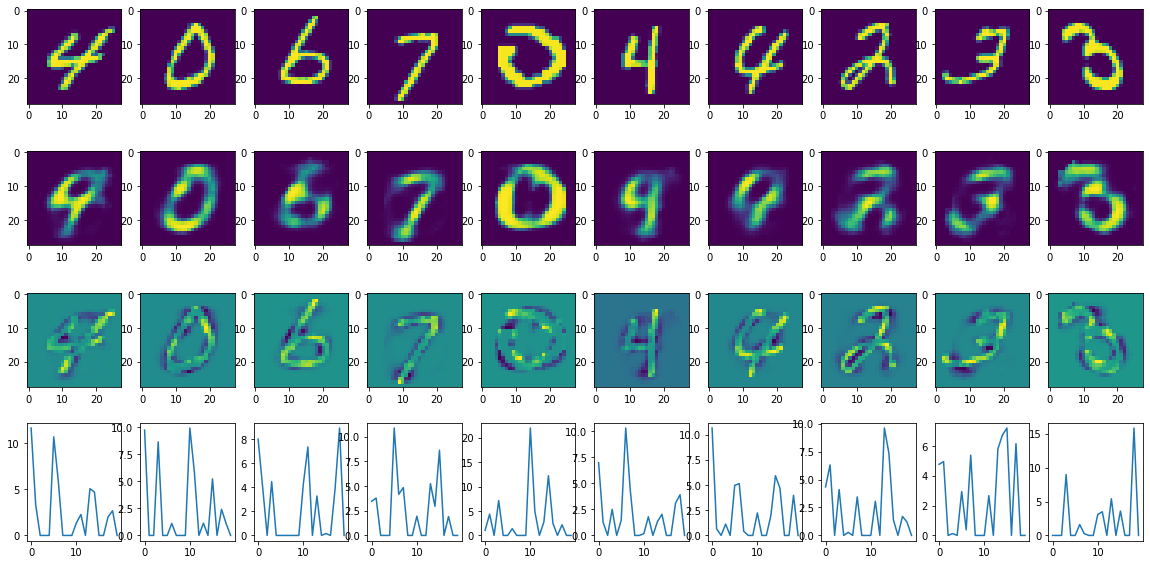

Test MSE: [0.02810156665146351, 0.028101565]


In [7]:
encoder, decoder = dense_autoencoder(x_train, hidden_layers=[20])
train_test(x_train, x_test, encoder, decoder, 'single-layer-dense-auto-encoder')

In [0]:
# Clean up time.
del encoder, decoder

## Multi-layer dense auto-encoder.
Just adding entries to the `hidden_layers` list results in additional layers being added to the encoder and decoder networks.
If `hidden_layers=[64, 32]`, the 28x28x1 input gets flattened to a 784 element vector that gets passed to the 64-node hidden layer, then to the 32-node code layer.
The decoder takes that 32-element representation as input, passes it through a 64-node hidden layer and then a 784-node dense layer, before reshaping it into a 28x28x1 image.

Does adding hidden layers actually help? Yes, it does reduce reconstruction error when the code layer has a small number of nodes.
If the code layer has many nodes, adding hidden layers actually reduces reconstruction accuracy (increased mean-squared error).

Training data shape: (40000, 28, 28, 1)
Validation data shape: (20000, 28, 28, 1)
Model: "model_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        [(None, 28, 28, 1)]       0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_20 (Dense)             (None, 128)               100480    
_________________________________________________________________
dense_21 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_22 (Dense)             (None, 20)                1300      
_________________________________________________________________
dense_23 (Dense)             (None, 64)                1344      
__________________________________________

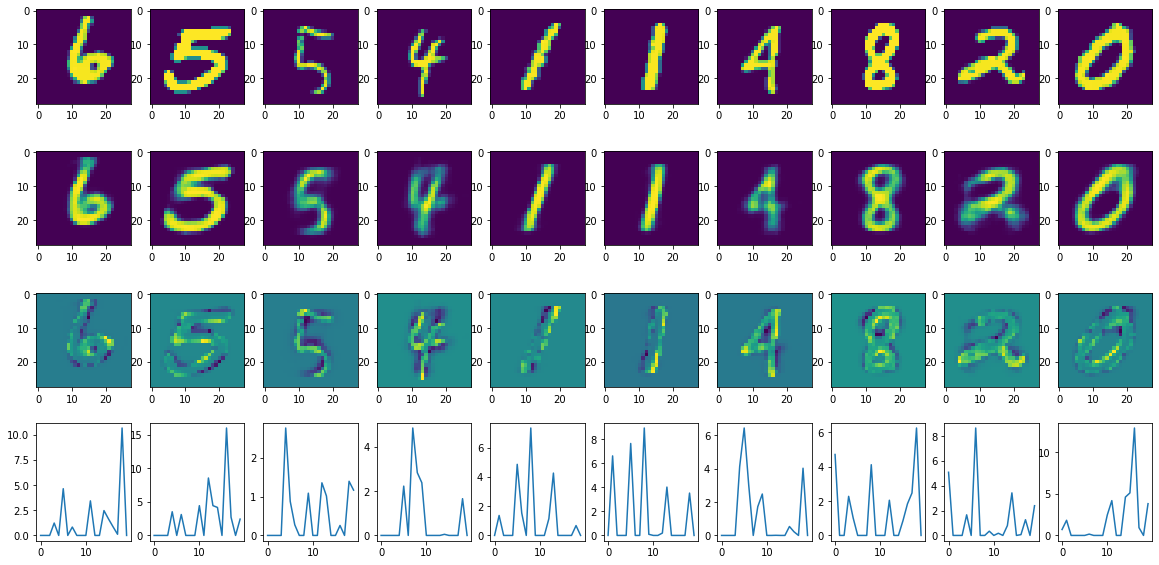

Test MSE: [0.026151975485682488, 0.02615196]


In [0]:
encoder, decoder = dense_autoencoder(x_train, hidden_layers=[128, 64, 20])
train_test(x_train, x_test, encoder, decoder, 'multi-layer-dense-auto-encoder')

In [0]:
# Clean up time.
del encoder, decoder

## Sparse auto-encoders
In order to turn the dense auto-encoders above into sparse auto-encoders, all we have to do is penalise the output (activations) or the code layer, specifically using the L1 loss.
This is achieved by passing `activity_regularizer=tf.keras.regularizers.l1(sae_l1)` to the constructor for the code layer. The penalty `sae_l1` shouldn't be too large, e.g. 1e-3 resulted in terrible reconstruction errors.

Training data shape: (40000, 28, 28, 1)
Validation data shape: (20000, 28, 28, 1)
Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               401920    
_________________________________________________________________
dense_3 (Dense)              (None, 784)               402192    
_________________________________________________________________
reshape_1 (Reshape)          (None, 28, 28, 1)         0         
Total params: 804,112
Trainable params: 804,112
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
1000/1000 [===============

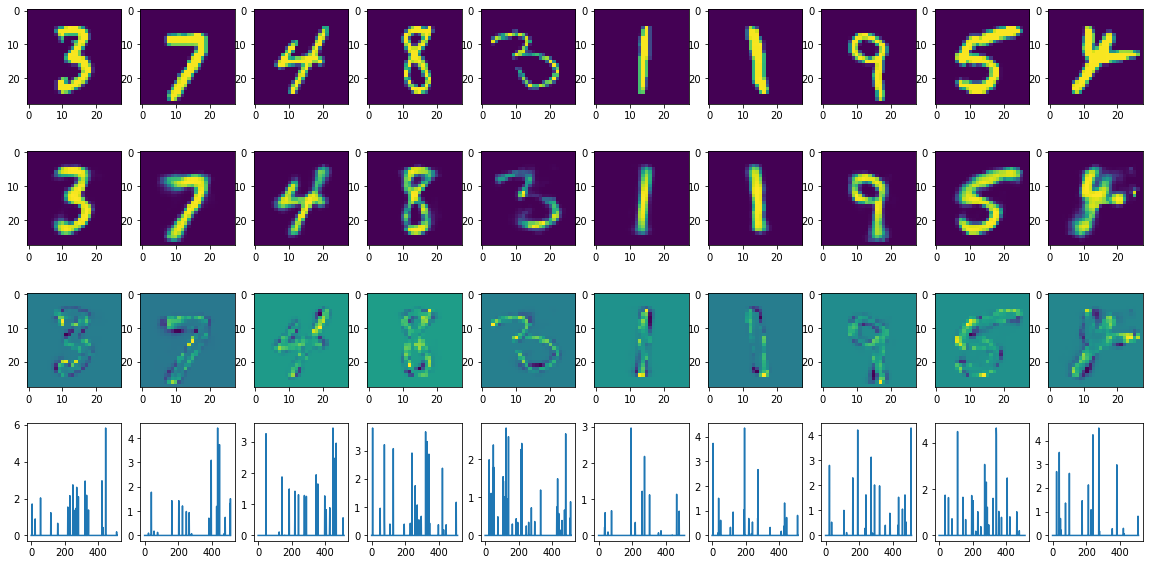

Test MSE: [0.01913576319217682, 0.015557111]


In [0]:
encoder, decoder = dense_autoencoder(x_train, hidden_layers=[512], sae_l1=1e-4)
train_test(x_train, x_test, encoder, decoder, 'sparse-single-layer-dense-auto-encoder')

In [0]:
# Clean up time.
del encoder, decoder

## Convolutional auto-encoder
Here, the encoder consists of a sequence of convolution and pooling layers, optionally followed by one or more dense layers. The decoder mirrors these dense layers, followed by a sequence of convolution and upsampling layers matching the encoder the architecture. The dense layers in between are optional, as the latent representation could be a low resolution image with a number of channels.

In [0]:
def convolutional_autoencoder(x_train: np.ndarray, hidden_layers: list, fc_layers: list=None, l1=0, l2=0, sae_l1=0):
    X = tf.keras.layers.Input(shape=x_train.shape[1:], name='input')
    h = X
    idx = 1
    for layer in hidden_layers[:-1]:
        h = tf.keras.layers.Conv2D(
            layer,
            (3, 3),
            name=f'encode_conv_{idx}',
            padding='same',
            activation='relu',
            kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1, l2=l2))(h)
        h = tf.keras.layers.MaxPooling2D((2, 2), name=f'encode_pool_{idx}')(h)
        idx += 1
    if fc_layers is None:
        conv_activity_reg = tf.keras.regularizers.l1(sae_l1)
        fc_activity_reg = None
    else:
        conv_activity_reg = None
        fc_activity_reg = tf.keras.regularizers.l1(sae_l1)
    h = tf.keras.layers.Conv2D(
        hidden_layers[-1],
        (3, 3),
        name=f'encode_conv_{idx}',
        padding='same',
        activation='relu',
        kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1, l2=l2),
        activity_regularizer=conv_activity_reg)(h)
    h = tf.keras.layers.MaxPooling2D((2, 2), name=f'encode_pool_{idx}')(h)
    
    conv_shape = h.shape
    idx = 1
    if not fc_layers is None:
        # Flatten the convolutional layer output.
        h = tf.keras.layers.Flatten(name='2d-to-1d')(h)
        for layer in fc_layers[:-1]:
            h = tf.keras.layers.Dense(
                layer,
                name=f'encode_fc_{idx}',
                activation='relu',
                kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1, l2=l2))(h)
            idx += 1
        h = tf.keras.layers.Dense(
            fc_layers[-1],
            name=f'encode_fc_{idx}',
            activation='relu',
            kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1, l2=l2),
            activity_regularizer=tf.keras.regularizers.l1(sae_l1))(h)
    encoder = tf.keras.Model(inputs=[X], outputs=[h])
    encoder.compile('adam', loss='mse')
    
    # Decoder section.
    idx = 1
    if not fc_layers is None:
        for layer in fc_layers[-2::-1]:
            h = tf.keras.layers.Dense(
                layer,
                name=f'decode_fc_{idx}',
                activation='relu',
                kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1, l2=l2))(h)
            idx += 1
        h = tf.keras.layers.Dense(
            np.prod(conv_shape[1:]),
            name=f'decode_fc_{idx}',
            activation='sigmoid',
            kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1, l2=l2))(h)
        h = tf.keras.layers.Reshape(conv_shape[1:], name='1d-to-2d')(h)
    idx = 1
    for layer in hidden_layers[:0:-1]:
        h = tf.keras.layers.Conv2D(
            layer,
            (3, 3),
            name=f'decode_conv_{idx}',
            padding='same',
            activation='relu',
            kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1, l2=l2))(h)
        h = tf.keras.layers.UpSampling2D((2, 2), name=f'decode_up2d_{idx}')(h)
        idx += 1
    h = tf.keras.layers.Conv2D(
        hidden_layers[0],
        (3, 3),
        name=f'decode_conv_{idx}',
        padding='same',
        activation='relu',
        kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1, l2=l2))(h)
    h = tf.keras.layers.UpSampling2D((2, 2), name=f'decode_up2d_{idx}')(h)
    idx += 1
    h = tf.keras.layers.Conv2D(
        1,
        (3, 3),
        name=f'decode_conv_{idx}',
        padding='same',
        activation='sigmoid',
        kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1, l2=l2))(h)
    decoder = tf.keras.Model(inputs=[X], outputs=[h])
    decoder.compile(
        tf.keras.optimizers.RMSprop(lr=0.001),
        loss='mse',
        metrics=['mse'])
    return encoder, decoder

In [34]:
encoder, decoder = convolutional_autoencoder(x_train, hidden_layers=[32], fc_layers=[20])
train_test(x_train, x_test, encoder, decoder, 'single-layer-convolutional-auto-encoder')

Training data shape: (40000, 28, 28, 1)
Validation data shape: (20000, 28, 28, 1)
Model: "model_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(None, 28, 28, 1)]       0         
_________________________________________________________________
encode_conv_1 (Conv2D)       (None, 28, 28, 32)        320       
_________________________________________________________________
encode_pool_1 (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
flatten_10 (Flatten)         (None, 6272)              0         
_________________________________________________________________
encode_fc_1 (Dense)          (None, 20)                125460    
_________________________________________________________________
decode_fc_1 (Dense)          (None, 6272)              131712    
__________________________________________

KeyboardInterrupt: ignored

In [0]:
# Clean up time.
del encoder, decoder

In [36]:
encoder, decoder = convolutional_autoencoder(x_train, hidden_layers=[32, 32], fc_layers=[128, 20])
train_test(x_train, x_test, encoder, decoder, 'multi-layer-convolutional-auto-encoder')

Training data shape: (40000, 28, 28, 1)
Validation data shape: (20000, 28, 28, 1)
Model: "model_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        [(None, 28, 28, 1)]       0         
_________________________________________________________________
encode_conv_1 (Conv2D)       (None, 28, 28, 32)        320       
_________________________________________________________________
encode_pool_1 (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
encode_conv_2 (Conv2D)       (None, 14, 14, 32)        9248      
_________________________________________________________________
encode_pool_2 (MaxPooling2D) (None, 7, 7, 32)          0         
_________________________________________________________________
flatten_12 (Flatten)         (None, 1568)              0         
__________________________________________

KeyboardInterrupt: ignored

In [0]:
# Clean up time.
del encoder, decoder